# Eluvio Data Challenge
## Problem Definition: Predict the Popularity of News Articles using Headlines
* Dataset Description: It contains news headlines from 2008-01-25 to 2016-11-22, with related attributes: time created, date_created, upvotes, down_votes, authors, over_18 (Whether the news has NSFW content or not).
* Since we have upvotes and down_votes data, which can be used to measure popularity, it is straightforward to think of building a model to predict the popularity with headlines.
    * Why do business need this model?
        * Headlines are vital in capturing readers’ attention. An attracitve headline may increase readers' willingness to click the news, thus lead to **higher click-through rate and advertising effect**.
        * Business can decide the advertising strategy depending on the prediction.
        * Also, author may realize what kinds of terms in headlines are more eye-attracting.
* Workflow<br>
&emsp;1. Exploratory Data Analysis<br>
&emsp;2. Data Preprocessing<br>
&emsp;3. Feature Engineering<br>
&emsp;4. Topic Modeling<br>
&emsp;5. Classification Model<br>
&emsp;6. Future works<br>

## Exploratory Data Analysis

### Load Packges

In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
import spacy
from geotext import GeoText
import numpy as np
from multiprocessing import Pool
from collections import Counter
from datetime import datetime, timedelta

### Load dataset and Preview

In [2]:
df=pd.read_csv('Eluvio_DS_Challenge.csv')

In [3]:
print('show the first 5 rows')
df.head()

show the first 5 rows


,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


We can see that 'time_created' is in Unix timestamp format, so we first convert this column into datetime type because it will be better understanding and easier to manipulate. Also, do the same thing on 'date_created'. 

In [4]:
df['time_created']=pd.to_datetime(df['time_created'],unit='s')
df['date_created'] = pd.to_datetime(df['date_created'])
print('show the first 5 rows after changing to datetime type')
df.head()

show the first 5 rows after changing to datetime type


,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,2008-01-25 03:34:06,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,2008-01-25 03:34:35,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,2008-01-25 03:42:03,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,2008-01-25 03:54:50,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,2008-01-25 15:25:20,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In addition to date, now we also get time in hour,minute and second level! <br>
That's take a look of whole dataset's summary.

In [5]:
print('====Dataset summary====')
df.info()
print('\n')
print('====Show first 5 unique values for each column====')
for column in ['up_votes','down_votes','author','over_18','category']:
    uniques = df[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

====Dataset summary====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
time_created    509236 non-null datetime64[ns]
date_created    509236 non-null datetime64[ns]
up_votes        509236 non-null int64
down_votes      509236 non-null int64
title           509236 non-null object
over_18         509236 non-null bool
author          509236 non-null object
category        509236 non-null object
dtypes: bool(1), datetime64[ns](2), int64(2), object(3)
memory usage: 27.7+ MB


====Show first 5 unique values for each column====
up_votes              5782	 [ 3  2  1  4 15]
down_votes               1	 [0]
author               85838	 ['polar' 'fadi420' 'mhermans' 'Armagedonovich' 'Clythos']
over_18                  2	 [False  True]
category                 1	 ['worldnews']


We can obeserve that this dataset does not contains Nan.<br>
Also, we find out that all values in 'down_votes' and 'category' are identical, which means we can drop them.

In [6]:
del df['down_votes'], df['category']

### Investigate in each column 
Let's inspect each column one by one.<br>
First, by using 'date_created' and 'time_created' to get information beyond date, like day of the week, pm/am.

In [7]:
def get_time_feature(df):
    df['day_of_week']=df['date_created'].dt.dayofweek
    df['day_of_week_name']=df['date_created'].dt.day_name()
    df['year'] = df['date_created'].dt.year
    df['month'] = df['date_created'].dt.month
    df['day'] = df['date_created'].dt.day
    df['weekend']=(df['date_created'].dt.dayofweek).apply(lambda x: 1 if x>4 else 0)
    #transfer to 24-hour-type
    df['day_time_hour']=df['time_created'].dt.hour+df['time_created'].dt.minute/60+df['time_created'].dt.second/3600 
    df['pm']=df['day_time_hour'].apply(lambda x: 1 if x>12 else 0) #whether the news posted in pm or not
    return df
df=get_time_feature(df)

Text(0.5, 1.0, 'Avg upvotes vs Year')

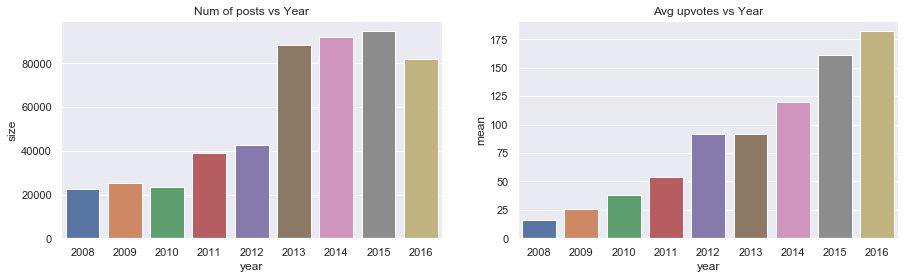

In [8]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
g=df.groupby('year')['up_votes'].agg(['size', 'mean'])
sns.barplot(x=g.index,y=g['size'],ax=ax[0]).set_title('Num of posts vs Year')
sns.barplot(x=g.index,y=g['mean'],ax=ax[1]).set_title('Avg upvotes vs Year')

Text(0.5, 1.0, 'Avg upvotes vs Day of week')

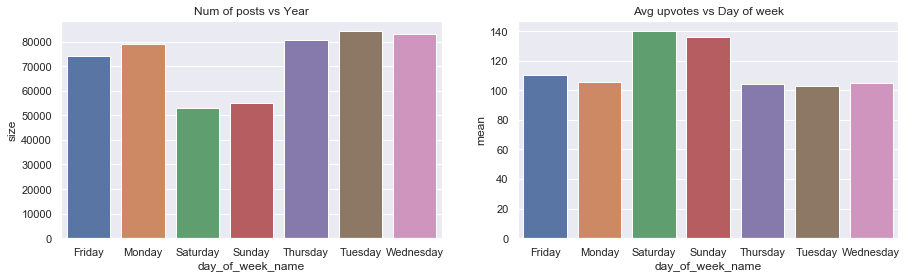

In [9]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
g=df.groupby('day_of_week_name')['up_votes'].agg(['size', 'mean'])
sns.barplot(x=g.index,y=g['size'],ax=ax[0]).set_title('Num of posts vs Year')
sns.barplot(x=g.index,y=g['mean'],ax=ax[1]).set_title('Avg upvotes vs Day of week')

Text(0.5, 1.0, 'Avg upvotes vs day time')

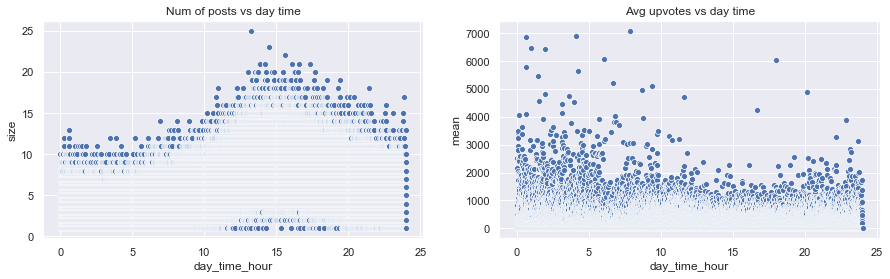

In [10]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
g=df.groupby('day_time_hour')['up_votes'].agg(['size', 'mean'])
sns.scatterplot(x=g.index, y=g['size'],ax=ax[0]).set_title('Num of posts vs day time')
sns.scatterplot(x=g.index, y=g['mean'], ax=ax[1]).set_title('Avg upvotes vs day time')

From the above images, we know that there is a increasing trend inf number of posts for year-level. Also, it seems that news posted on the weekend can obtain more upvotes. And most posts are at aroud 3pm.

Then, let's see 'over_18' column.

False    508916
True        320
Name: over_18, dtype: int64


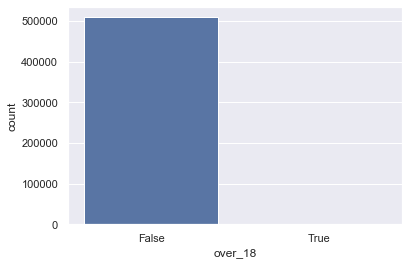

In [11]:
print(df['over_18'].value_counts())
sns.countplot(df['over_18'])

Most news are SFW. <br>
We now consider 'up_votes', the important measurment for popularity.

====Summary of up_votes====
count    509236.000000
mean        112.236283
std         541.694675
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max       21253.000000
Name: up_votes, dtype: float64


Text(0.5, 1.0, 'The distribution of Upvotes ')

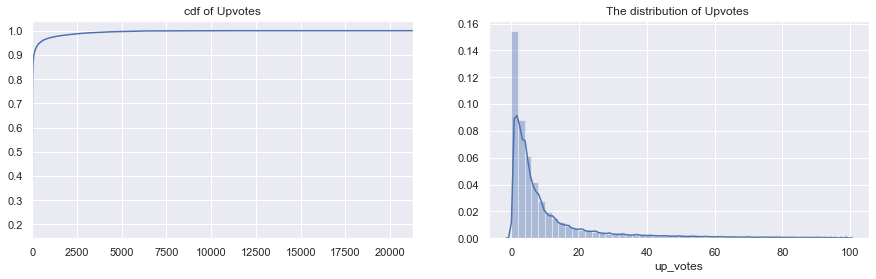

In [12]:
print('====Summary of up_votes====')
print(df['up_votes'].describe())
f, axes = plt.subplots(1, 2,figsize=(15, 4))
(df['up_votes'].value_counts().sort_index().cumsum()/len(df['up_votes'])).plot(title='cdf of Upvotes',ax=axes[0])
#show only the first 90%
sns.distplot(df[df['up_votes']<100]['up_votes'],ax=axes[1]).set_title('The distribution of Upvotes ') 

The range of up_votes is very big. Most of the up_vote (75%) are less than 16, and the outliers are very obvious (with maxium of 21253 up_votes). We leave how we define popularity in later part.<br>
Author also plays a important role in news popularity. However, since there are too many authors in our dataset, here we only plot the ones who posted the most.

====Top 15 productive authors====


Text(0.5, 1.0, 'Author vs Up_votes sum')

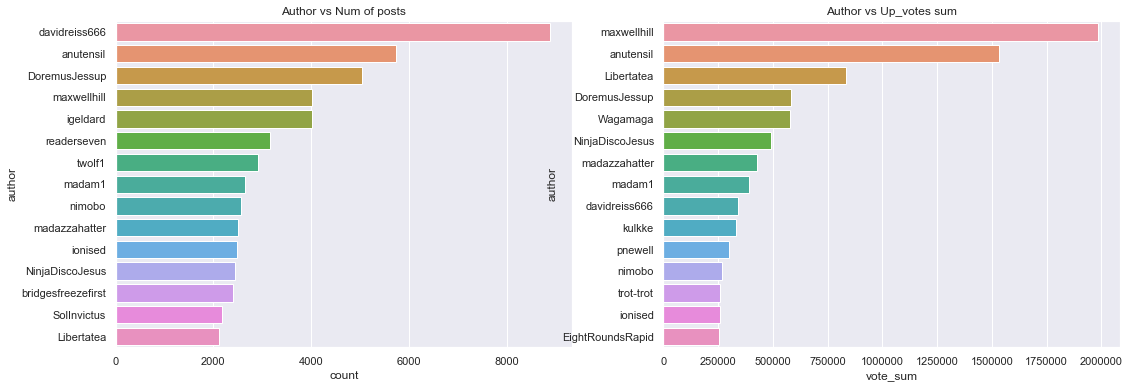

In [13]:
print('====Top 15 productive authors====')
f, ax = plt.subplots(1, 2, figsize=(18, 6))
num = 15
sns.countplot(y=df['author'],order = df['author'].value_counts().iloc[:num].index, ax=ax[0]).set_title('Author vs Num of posts')

g=pd.DataFrame(df.groupby('author')['up_votes'].sum().sort_values(ascending=False))
g['vote_sum']=g['up_votes']
sns.barplot(y=g.index[:num],x=g['vote_sum'].iloc[:num],ax=ax[1]).set_title('Author vs Up_votes sum')

Finally, we now foucs on the most important feature, 'title'. Since titiles are text which requires further preprocessing, here we only do a simple analysis. The complete analysis will be discuessed in next part. <br>
By observing the text, we find out that some headlines coming along with \[video\] or \[pic\] tags. To see whether the tags is up_votes or not, just do a simple t-test.

In [14]:
print('====Count for have_pic_video or not====')
df['have_pic_video']=df['title'].str.contains('\[video\]|\[pic\]')
print(df['have_pic_video'].value_counts())
print('\n')
print('====t-test====')
import scipy
scipy.stats.ttest_ind(df[df.have_pic_video==False]['up_votes'],df[df.have_pic_video==True]['up_votes'],equal_var=False)

====Count for have_pic_video or not====
False    509081
True        155
Name: have_pic_video, dtype: int64


====t-test====


Ttest_indResult(statistic=1.27389948308252, pvalue=0.2046151565507766)

The p-value is larger than 0.05 or 0.1=> can not reject. Having such tags may not have impact to up_votes. <br>
Now, let's see each title's length.

Text(0.5, 1.0, 'Avg upvotes vs title_length')

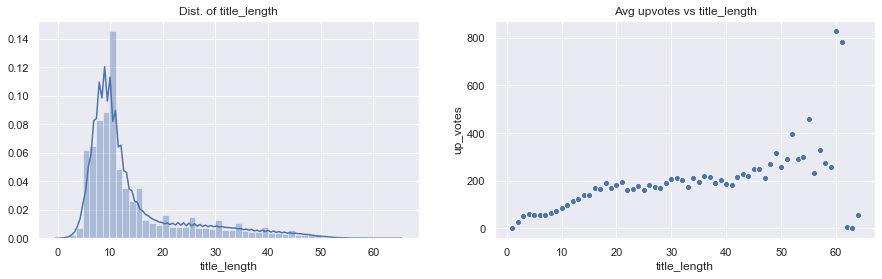

In [15]:
df['title_length']=df['title'].apply(lambda x: len(x.split()))
f, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(df['title_length'],ax=ax[0]).set_title('Dist. of title_length')
g=df.groupby('title_length')['up_votes'].mean()
sns.scatterplot(x=g.index,y=g,ax=ax[1]).set_title('Avg upvotes vs title_length')

When title's length exceed around 55 words, the average upvotes decreases.

## Data Preprocessing

In [16]:
df['title']=df['title'].str.replace('\[video\]|\[pic\]','') #remove tags
df['title']=df['title'].str.replace(r'\.','') #ex: U.S., U.S => US, US
df['title']=df['title'].str.replace(r'[^a-zA-Z\s]',' ') #remove(non alphabetic character)
df['title']=df['title'].str.replace(r'\s+',' ') #remove(\t,\n,\r)

After preprocessing, we would like to extract country name from headlines. The assumption here is that: when there is a big event in a certain country like tokyo olympics 2020, the popularity of news related to Japan may increase. Country name may be helpful to predicting popularity.

In [17]:
df['country']=df['title'].apply(lambda x: GeoText(x).countries)
df['country']=df['country'].apply(lambda x: x if x else np.nan)

In [18]:
print('show extracting result')
df[['title','country']].loc[0]

show extracting result


title      Scores killed in Pakistan clashes
country                           [Pakistan]
Name: 0, dtype: object

Since a headline may contain multiple country name, here we only pick the first apper one, to plot the ocurrence of each country name

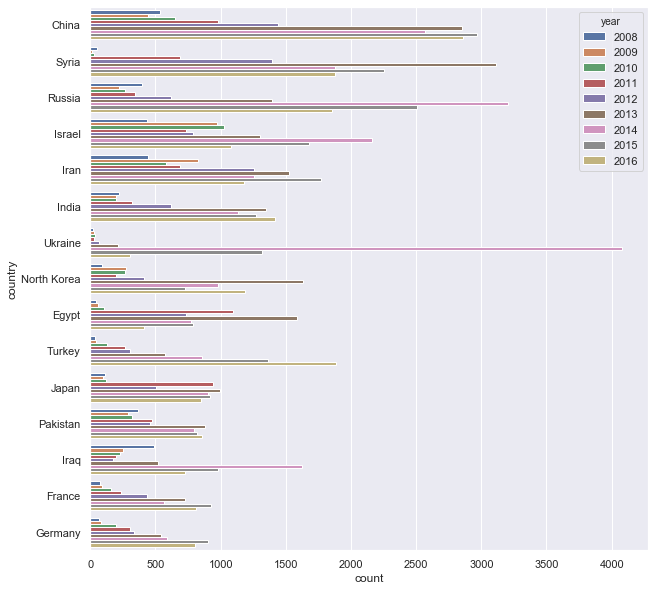

In [19]:
t=df[['country','year']].dropna()
t['country']=t['country'].apply(lambda x: x[0])
fig = plt.figure(figsize=(10,10))
num = 15
sns.countplot(y=t['country'],order = t['country'].value_counts().iloc[:num].index, hue=t['year'])

From the above image, we find that many news mentioned Ukraine in 2014. It is because of 2014 Ukraine evolution.

## Feature Engineering

### Non-text features
We first transform categorical_feature like 'over_18','weekend' into one-hot encoding. <br>
And use an author's total posts in training set as author features. 

In [23]:
def get_categorical_feature(x):
    x=pd.concat([pd.get_dummies(x['pm']),pd.get_dummies(x['weekend']),
               pd.get_dummies(x['over_18']),pd.get_dummies(x['have_pic_video'])],axis=1)
    return x.values
def author_encoding(train,test):
    post_dict=train.groupby('author').size().to_dict()
    train['author_total_posts']=train['author'].map(post_dict)
    test['author_total_posts']=test['author'].map(post_dict).fillna(1)
    return train,test

In addition to above features, how to let machine understand text is also a problem. Here we have tried different word-vec representations, such as bag-of-words and word2vec. <br>

### Bag-of-words
First, we utilize bag-of-words model (counting each word' occurrence to indicate a word). <br>
Unlike traditional text, headlines are more possible to contains acronyms, which are case sensitive (ex: US is different from us). Also, not every word is important. Some stopword like 'the' or 'a' must be excluded. What's more, since word may have different type (past, ving), coverting them into an unified type is also important when counting. So, an extra tokenization is needed.<br>

In [24]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

def remove_stopword_and_lemm(x):
    stop_words = set(stopwords.words('english'))
    new_word=[word for word in x.split() if word not in stop_words]
    lemma=WordNetLemmatizer() 
    clean_word=[lemma.lemmatize(w,'v') for w in new_word]
    return " ".join(clean_word)

def tokenize_word_count(x):
    #the original text do no have ' between word and s or t, ex: don t. Add ' into it so they can be matched in stop_words
    x=x.str.replace(r'\st\s',"'t ") 
    x=x.str.replace(r'\ss\s',"'s ")
    x=x.str.replace(r'\bUK\b','uk')
    x=x.str.replace(r'\bEU\b','eu')
    #only lowercase wors with Upper initial ex: Japan=> japan, APPL=>APPL
    x=x.str.replace(r'\b([A-Z])[a-z]+\b', lambda m: m.group(0).lower()) 
    x=x.apply(remove_stopword_and_lemm)
    return x

In [25]:
s=tokenize_word_count(df['title'])

In [26]:
print('====show tokenization====')
print('before :' +df['title'].loc[4])
print('After :' +s.loc[4])

====show tokenization====
before :Council of Europe bashes EU UN terror blacklist
After :council europe bash eu UN terror blacklist


====Wordcould Visualization====


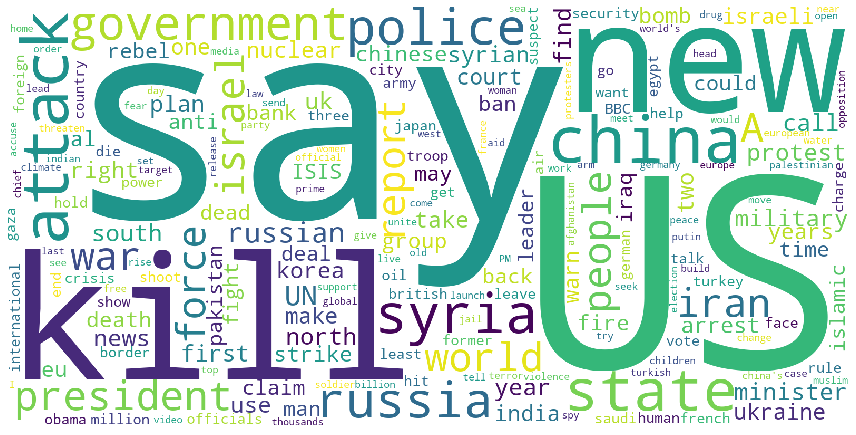

In [30]:
print('====Wordcould Visualization====')
ss=' '.join(s).split()
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800,background_color='white').generate_from_frequencies(Counter(ss))
fig = plt.figure(figsize=(12,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout()
plt.show()

### Word2vec

Since bag-of-word model only considers the ocurrence of word, neglecting the text structure. While Word2vec can deal with such problem, here we use pre-trained embedding of Google-news. Since the pre-train embedding is trained on news, it has terms like 'UN'(United Nations), 's' (for 's). So we do not have to do further preprocessing. By averaging each word's embedding in a headline, we get the final vector representation, docvec.

In [31]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [32]:
def get_doc_vec(x):
    vec=[]
    word_list=x.split()
    for word in word_list:
        if word in wv.vocab:
            vec.append(wv[word])
    if vec:
        return np.mean(vec,axis=0)
    else:
        return np.nan
def f1(x):
    return x.apply(get_doc_vec)

#use multiprocessing to speed up
p = Pool(8)
l=p.map(f1, np.array_split(df['title'], 8))
df['docvec']=pd.concat(l)
df=df.dropna() #if there is no any word matched in pre-train embedding, drop it

====Visualization by TSNE====


68

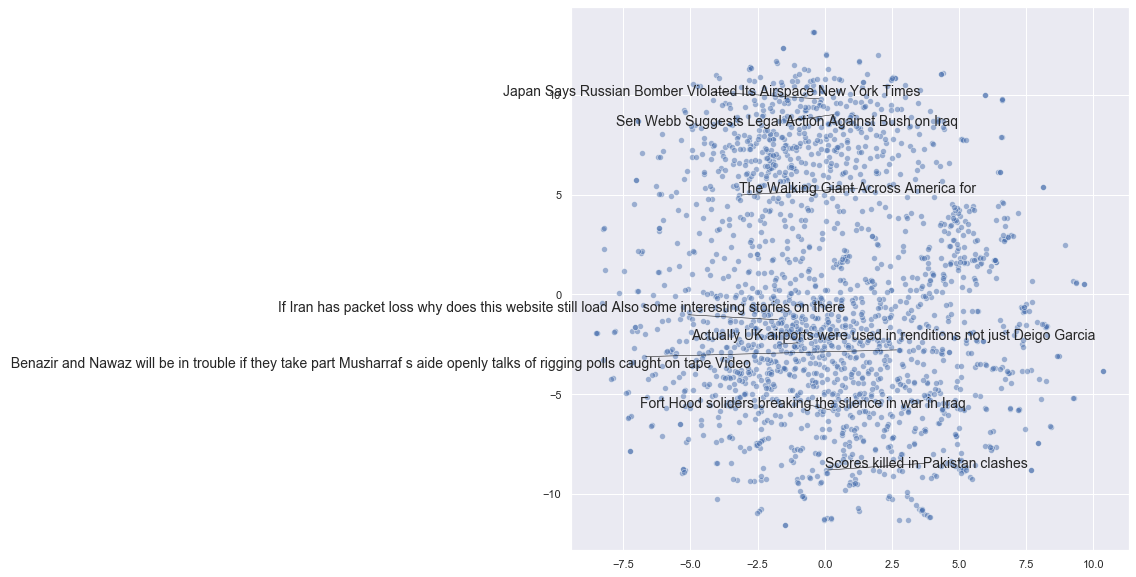

In [38]:
print('====Visualization by TSNE====')
from sklearn.manifold import TSNE
from adjustText import adjust_text
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
tsne_df = tsne.fit_transform(np.array(df['docvec'].iloc[0:2000].to_list())) # Use only 2000 rows to shorten processing time

fig, ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

texts = []
titles_to_plot = list(np.arange(0, 400, 50)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], df['title'].iloc[title], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

### Get Trend Word
As we have mentioned before, country names are important when they are integrated with datetime (ex: Japan+2020 may receive more upvote, but Japan+2018 might not). But using 'year' or 'date' as feature is not realistic because it has no generalization. So we do in another approach. For each headline, we extract most recently trend word, the country names in all titles posted in last week and with high upvotes (>5(median)). Then count this headlines containing how many trend word as another feature.

In [39]:
def have_trend_word(x):
    end_date=x['date_created']
    start_date=x['date_created']-timedelta(days=8)
    g=df[(df.date_created>=start_date)&(df.date_created<end_date)]
    g=g[g.up_votes>5].dropna()['country']
    if len(g)==0:
        return 0
    trend_word=set(np.hstack(g.tolist()))
    count=0
    for i in x['title'].split():
        if i in trend_word:
            count=count+1
    return count

In [40]:
#this step should be parallelized.
count_list=[]
for index, row in df.iterrows():
    count_list.append(have_trend_word(row))
df['have_trend_word']= count_list

## Topic Modeling

In order to find what kinds of topic may attract upvotes, we use LDA to conduct topic modeling with bag-of-words model. We randomly sample 50000 data to do a quick experiment.

In [41]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
# Helper function
vectorizer = CountVectorizer(lowercase=False)
count_data = vectorizer.fit_transform(s.sample(n=50000, random_state=1))
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
#Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

Topics found via LDA:

Topic #0:
china find year say new japan years court india world

Topic #1:
say drug US world afghanistan kill people afghan taliban police

Topic #2:
say russia US president syria minister UN eu war new

Topic #3:
israel attack israeli al gaza egypt dead news palestinian US

Topic #4:
kill US north korea say state attack bomb police south


It seems like there is not significant difference between each topic. Thus, we temporarily omit the information we get here in predicting predicting. May do further research in future works.

## Classification Model
Finally, we now build up our classification model. We transform the predicting popularity task into a binary classification problem. The label depends on up_votes, while upvotes>5 (median) is 1, otherwise 0. We use median to split the label to prevent from data imbalance. <br>
We split training and testing set randomly using the ratio of 7:3.

In [42]:
df['label']=0
df.loc[(df.up_votes>5),'label']=1
df['label'].value_counts()

0    275789
1    233381
Name: label, dtype: int64

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df, df['label'],test_size=0.3,random_state=101)

In [45]:
#aggregate all feature
X_train,X_val=author_encoding(X_train,X_val)
X_train_feature=np.concatenate((np.array(X_train['docvec'].tolist()), 
                                get_categorical_feature(X_train),
                                X_train['title_length'].values.reshape(-1,1),
                               X_train['author_total_posts'].values.reshape(-1,1),
                               X_train['have_trend_word'].values.reshape(-1,1)), axis=1)
X_val_feature=np.concatenate((np.array(X_val['docvec'].tolist()), 
                              get_categorical_feature(X_val),
                              X_val['title_length'].values.reshape(-1,1),
                             X_val['author_total_posts'].values.reshape(-1,1),
                             X_val['have_trend_word'].values.reshape(-1,1)), axis=1)

In [46]:
#show feature size
X_train_feature.shape

(356419, 311)

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

We choose LogisticRegression as our classifier because it is fast, robust and good for binary classification.

In [48]:
clf = LogisticRegression(random_state=0).fit(X_train_feature, y_train)

/Users/tim/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Testing Result

In [51]:
pred=clf.predict(X_val_feature)
print('Testing Accuracy:',accuracy_score(y_val, pred))

Testing Accuracy: 0.6044019351755471


In [52]:
confusion_matrix(y_val, pred)

array([[60300, 22459],
       [37969, 32023]])

In [54]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.61      0.73      0.67     82759
           1       0.59      0.46      0.51     69992

    accuracy                           0.60    152751
   macro avg       0.60      0.59      0.59    152751
weighted avg       0.60      0.60      0.60    152751



From above table, we can see that our model do capture some information, leading to 60% accuracy (>50%). <br>

## Future Work
* Use NER and POS tags as additional features.
* Trend words should include words beyond country name, such as diseases or company name.
* Conduct sentiment analysis.
* Try sequence model, like rnn, lstm